In [11]:
import pandas as pd
import torch
import seaborn as sns
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv  # Switch from GCNConv
import numpy as np
import os
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, f1_score

print("Libraries imported.")

Libraries imported.


In [14]:
csv_path = "data/data_processed/final_predictions.csv"
assert os.path.exists(csv_path), f"File not found: {csv_path}"
df = pd.read_csv(csv_path)

print(f"Loaded dataset: {df.shape}")
print(df["label"].value_counts())

# Filter and fill features
features = ["clip_score", "similarity_to_reference", "suspicious", "image_mismatch"]
df = df.dropna(subset=["label"])
for col in features:
    df[col] = df.get(col, 0).fillna(0)
    if df[col].dtype == bool:
        df[col] = df[col].astype(int)

# Normalize features
scaler = StandardScaler()
x = scaler.fit_transform(df[features])
x = torch.tensor(x, dtype=torch.float)

# Labels
label_map = {label: i for i, label in enumerate(df["label"].unique())}
y = torch.tensor(df["label"].map(label_map).values, dtype=torch.long)

# Enhanced edge_index: based on tweet proximity (assumes 'timestamp' in df)
if "timestamp" in df.columns:
    df = df.sort_values("timestamp").reset_index(drop=True)
    n = len(df)
    source_nodes = []
    target_nodes = []
    for i in range(n):
        for j in range(i+1, min(n, i+6)):
            source_nodes.append(i)
            target_nodes.append(j)
    edge_index = torch.tensor([source_nodes + target_nodes, target_nodes + source_nodes], dtype=torch.long)
else:
    n = len(df)
    edge_index = torch.stack([torch.arange(n - 1), torch.arange(1, n)], dim=0)

# Build graph
data = Data(x=x, edge_index=edge_index, y=y)

# Add train/test masks
data.train_mask = torch.zeros(n, dtype=torch.bool)
data.test_mask = torch.zeros(n, dtype=torch.bool)
train_cutoff = int(0.8 * n)
data.train_mask[:train_cutoff] = True
data.test_mask[train_cutoff:] = True

print("Graph data:", data)


Loaded dataset: (5, 9)
label
real    3
fake    2
Name: count, dtype: int64
Graph data: Data(x=[5, 4], edge_index=[2, 4], y=[5], train_mask=[5], test_mask=[5])


In [15]:
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GAT, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=4, concat=True)
        self.gat2 = GATConv(hidden_dim * 4, output_dim, heads=1, concat=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gat1(x, edge_index)
        x = F.elu(x)
        x = self.gat2(x, edge_index)
        return F.log_softmax(x, dim=1)

model = GAT(input_dim=x.shape[1], hidden_dim=16, output_dim=len(label_map))
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_fn = torch.nn.NLLLoss()

In [16]:
model.train()
for epoch in range(1, 101):
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    pred = out[data.train_mask].argmax(dim=1)
    acc = (pred == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Train Acc: {acc:.4f}")

Epoch 010 | Loss: 0.5921 | Train Acc: 0.7500
Epoch 020 | Loss: 0.4741 | Train Acc: 0.7500
Epoch 030 | Loss: 0.4397 | Train Acc: 0.7500
Epoch 040 | Loss: 0.4007 | Train Acc: 0.7500
Epoch 050 | Loss: 0.3532 | Train Acc: 0.7500
Epoch 060 | Loss: 0.2785 | Train Acc: 1.0000
Epoch 070 | Loss: 0.1538 | Train Acc: 1.0000
Epoch 080 | Loss: 0.0481 | Train Acc: 1.0000
Epoch 090 | Loss: 0.0144 | Train Acc: 1.0000
Epoch 100 | Loss: 0.0063 | Train Acc: 1.0000


In [17]:
model.eval()
out = model(data)
pred_test = out[data.test_mask].argmax(dim=1)
y_test = data.y[data.test_mask]
accuracy = (pred_test == y_test).sum().item() / y_test.size(0)
print(f"\n Test Accuracy: {accuracy:.4f}")

print("\n Classification Report:")
print(classification_report(y_test.cpu(), pred_test.cpu(), target_names=list(label_map.keys())))


 Test Accuracy: 0.0000

 Classification Report:
              precision    recall  f1-score   support

        real       0.00      0.00      0.00       1.0
        fake       0.00      0.00      0.00       0.0

    accuracy                           0.00       1.0
   macro avg       0.00      0.00      0.00       1.0
weighted avg       0.00      0.00      0.00       1.0



c:\Users\ASus\DisasterMisinformation.AI\venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ASus\DisasterMisinformation.AI\venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\ASus\DisasterMisinformation.AI\venv\lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

Using TSNE perplexity=2 for 5 nodes.


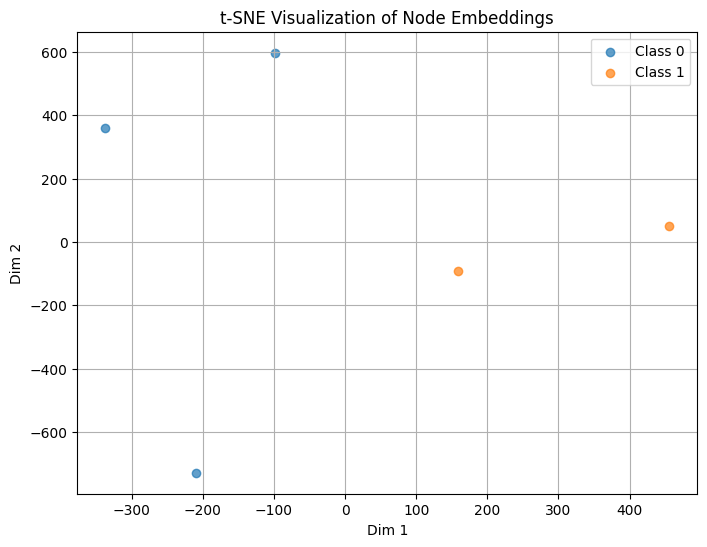

In [21]:
from sklearn.manifold import TSNE

model.eval()
with torch.no_grad():
    embeddings = model.gat1(data.x, data.edge_index).cpu().numpy()

n_samples = embeddings.shape[0]
adjusted_perplexity = min(30, max(2, n_samples // 3))  # robust fallback

print(f"Using TSNE perplexity={adjusted_perplexity} for {n_samples} nodes.")
tsne = TSNE(n_components=2, perplexity=adjusted_perplexity, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

labels = data.y.cpu().numpy()
plt.figure(figsize=(8, 6))
for label in np.unique(labels):
    idx = labels == label
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], label=f"Class {label}", alpha=0.7)
plt.legend()
plt.title("t-SNE Visualization of Node Embeddings")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.show()


In [20]:
model_path = "models/gnn_gat_model.pt"
os.makedirs("models", exist_ok=True)
torch.save(model.state_dict(), model_path)
print(f"GAT Model saved to {model_path}")


GAT Model saved to models/gnn_gat_model.pt
